<a href="https://colab.research.google.com/github/AnikBarua007/hqcnn_model/blob/main/HQCNN_ANIK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [5]:
!pip install qiskit qiskit-aer imbalanced-learn scikit-learn
!pip install pylatexenc
!pip install qiskit qiskit-aer
!pip install torch torchvision
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator, Aer
from imblearn.over_sampling import ADASYN
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, classification_report
import random
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)


In [6]:
# ...existing code...
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
# ...existing code...

Using device: cpu


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
root_dir = r"/content/drive/MyDrive/hqcnn_dataset/my dataset final 512x512(implemented)"
label_map = {'Normal': 0, 'stone': 1}
valid_ext = ('.jpg', '.jpeg', '.png')

In [9]:
def create_dataframe(root_dir):
    data = []
    for label_name in ['Normal', 'stone']:
        folder = os.path.join(root_dir, label_name)
        for file in os.listdir(folder):
            if file.lower().endswith(valid_ext):
                data.append([os.path.join(folder, file), label_map[label_name]])
    return pd.DataFrame(data, columns=['image_path', 'label'])


In [10]:
data_df = create_dataframe(root_dir)
data_df.dropna(inplace=True)

In [11]:
# Check unique classes and class distribution
print("Unique classes in the dataset:", data_df['label'].unique())
print("Class distribution:\n", data_df['label'].value_counts())

Unique classes in the dataset: [0 1]
Class distribution:
 label
1    5014
0    4467
Name: count, dtype: int64


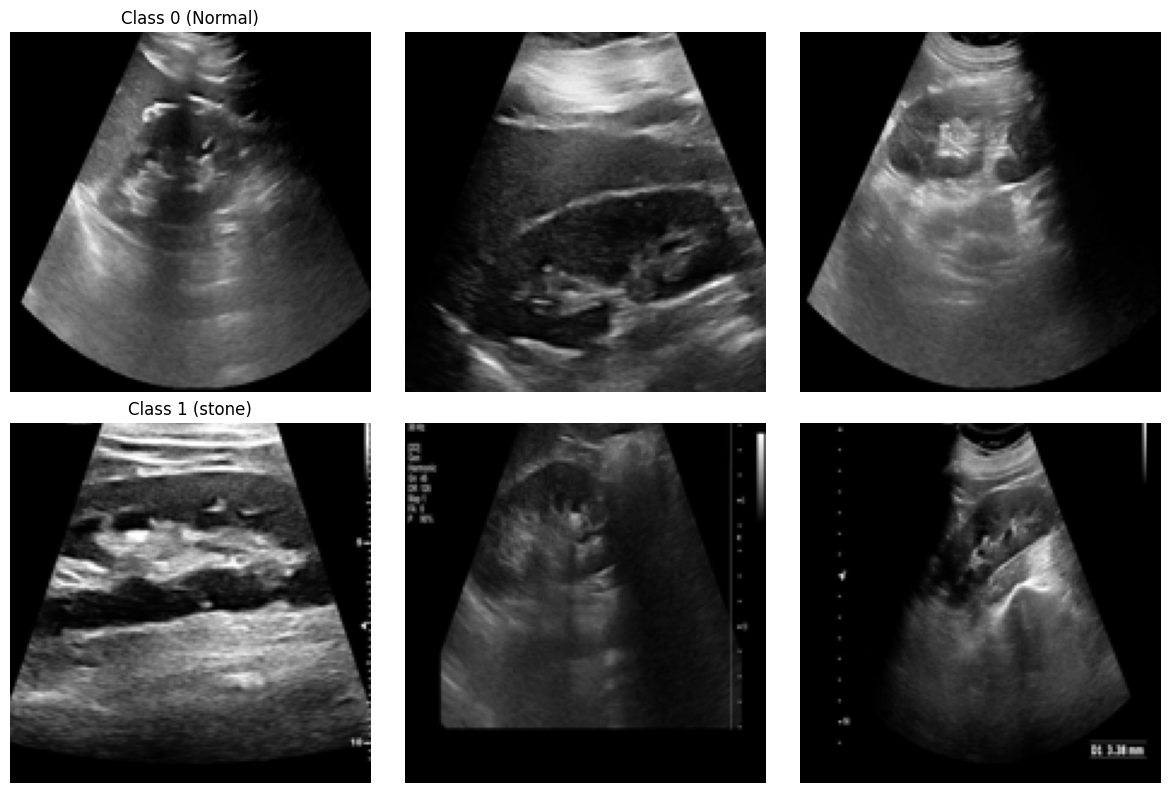

In [12]:
import matplotlib.pyplot as plt
from PIL import Image

def plot_sample_images(data_df, n_samples=3, target_size=(150, 150)):
    classes = sorted(data_df['label'].unique())
    fig, axes = plt.subplots(len(classes), n_samples, figsize=(4 * n_samples, 4 * len(classes)))
    for idx, cls in enumerate(classes):
        sample_paths = data_df[data_df['label'] == cls]['image_path'].sample(n=n_samples).tolist()
        for i, image_path in enumerate(sample_paths):
            img = Image.open(image_path).convert('L').resize(target_size)
            axes[idx, i].imshow(img, cmap='gray')
            axes[idx, i].axis('off')
            if i == 0:
                axes[idx, i].set_title(f"Class {cls} ({'Normal' if cls==0 else 'stone'})")
    plt.tight_layout()
    plt.show()

# Plot sample images from both classes
plot_sample_images(data_df, n_samples=3, target_size=(150, 150))

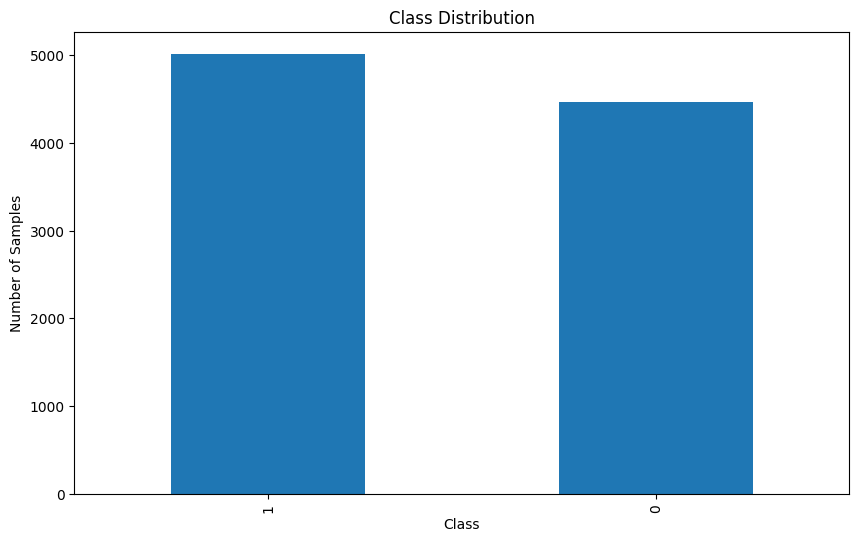

In [13]:
def plot_class_distribution(data_df):
    class_counts = data_df['label'].value_counts()
    plt.figure(figsize=(10, 6))
    class_counts.plot(kind='bar')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.show()
# Plot class distribution
plot_class_distribution(data_df)

In [14]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [15]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_and_resize_images(image_paths, target_size=(128, 128)):
    images = []
    for image_path in image_paths:
        img = load_img(image_path, target_size=target_size, color_mode='grayscale')
        img = img_to_array(img) / 255.0  # Normalize to [0, 1]
        images.append(img)
    return np.array(images)

X_images = load_and_resize_images(data_df['image_path'], target_size=(128, 128))

In [16]:

y_labels = data_df['label'].values

In [17]:
# Split the data into training and test sets using stratified splitting
X_train, X_test, y_train, y_test = train_test_split(X_images, y_labels, test_size=0.2, random_state=42, stratify=y_labels)

In [18]:
# Apply ADASYN to balance the training data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_flat, y_train)
X_train_resampled = X_train_resampled.reshape(-1, 128, 128, 1) # Fix: Use 128x128 for reshaping

In [19]:
# Function to plot class distribution
def plot_class_distribution(labels, title, color):
    df = pd.DataFrame(labels, columns=['label'])
    plt.figure(figsize=(10, 6))
    df['label'].value_counts().plot(kind='bar', color=color, alpha=0.7)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.show()

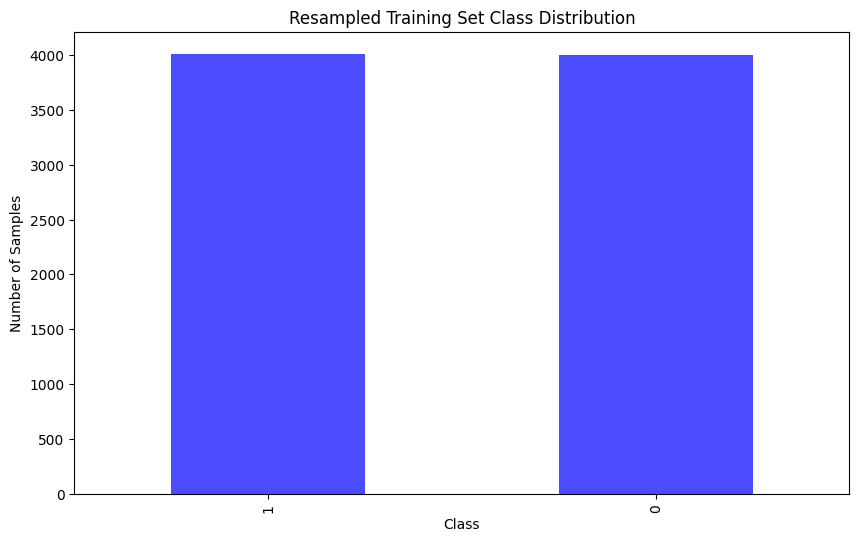

In [20]:
# Plot class distribution for the resampled training set
plot_class_distribution(y_train_resampled, 'Resampled Training Set Class Distribution', 'blue')

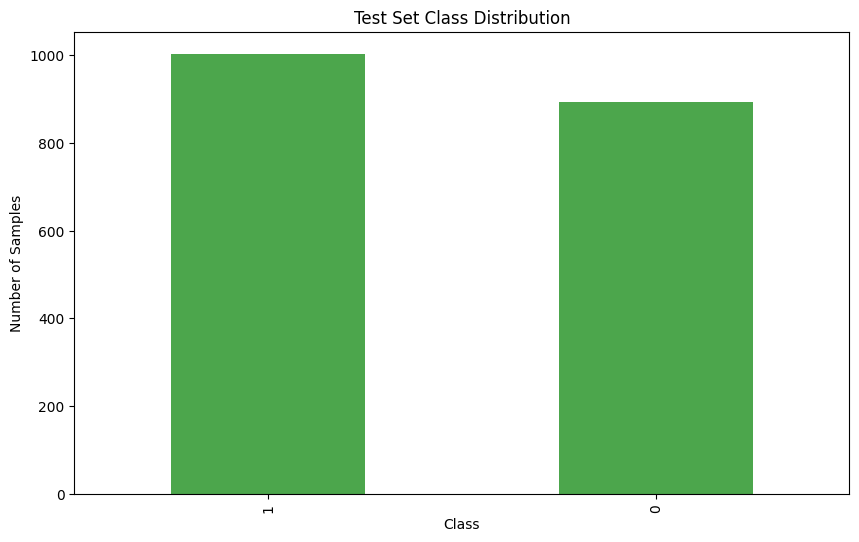

In [21]:
# Plot class distribution for the test set
plot_class_distribution(y_test, 'Test Set Class Distribution', 'green')

In [22]:
# Convert data to PyTorch tensors and reshape
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32).permute(0, 3, 1, 2)  # [batch, channels, height, width]
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)

In [23]:
# Convert labels to one-hot encoding
n_classes = len(data_df['label'].unique())
y_train_tensor = F.one_hot(torch.tensor(y_train_resampled, dtype=torch.long), num_classes=n_classes).float()
y_test_tensor = F.one_hot(torch.tensor(y_test, dtype=torch.long), num_classes=n_classes).float()

In [24]:
# Check tensor shapes
print(f"Shape of X_train_tensor: {X_train_tensor.shape}")
print(f"Shape of y_train_tensor: {y_train_tensor.shape}")
print(f"Shape of X_test_tensor: {X_test_tensor.shape}")
print(f"Shape of y_test_tensor: {y_test_tensor.shape}")

Shape of X_train_tensor: torch.Size([8012, 1, 128, 128])
Shape of y_train_tensor: torch.Size([8012, 2])
Shape of X_test_tensor: torch.Size([1897, 1, 128, 128])
Shape of y_test_tensor: torch.Size([1897, 2])


In [25]:
# Create DataLoader objects for training and testing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


//////////////////////////////////////////////////////////////  quantam circuits starts nowwwwwww

Expected value for rotation pi: -0.06
Counts: {'1': 100}


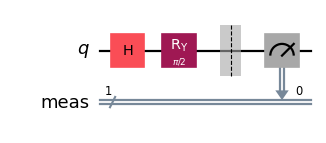

In [26]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator, Aer
import numpy as np

class MyQuantumCircuit:
    """
    Simple single-qubit quantum circuit for binary classification.
    """
    def __init__(self, n_qubits, backend, shots):
        self.n_qubits = n_qubits
        self.backend = backend
        self.shots = shots

    def run(self, theta):
        """
        Runs the quantum circuit with a given rotation angle theta.
        Returns the expectation value of Z for the measured qubit.
        """
        # Accept both float and list/array input
        if isinstance(theta, (list, np.ndarray)):
            theta = float(theta[0])
        else:
            theta = float(theta)
        circuit = QuantumCircuit(self.n_qubits)
        circuit.h(0)
        circuit.ry(theta, 0)
        circuit.measure_all()
        transpiled_circuit = transpile(circuit, self.backend)
        job = self.backend.run(transpiled_circuit, shots=self.shots)
        result = job.result()
        counts = result.get_counts()
        # For single qubit: keys are '0' and '1'
        prob_0 = counts.get('0', 0) / self.shots
        prob_1 = counts.get('1', 0) / self.shots
        expectation = prob_0 - prob_1
        return np.array([expectation], dtype=np.float32)

    def draw_circuit(self, theta):
        """
        Draws the quantum circuit for a given theta.
        """
        if isinstance(theta, (list, np.ndarray)):
            theta = float(theta[0])
        else:
            theta = float(theta)
        circuit = QuantumCircuit(self.n_qubits)
        circuit.h(0)
        circuit.ry(theta, 0)
        circuit.measure_all()
        transpiled_circuit = transpile(circuit, AerSimulator())
        job = AerSimulator().run(transpiled_circuit, shots=100)
        result = job.result()
        counts = result.get_counts(transpiled_circuit)
        print("Counts:", counts)
        figure = circuit.draw(output='mpl', scale=0.8)
        plt.show()
        return figure

# Example usage:
quantum_circuit = MyQuantumCircuit(1, AerSimulator(), 100)
print('Expected value for rotation pi:', quantum_circuit.run([np.pi])[0])
quantum_circuit.draw_circuit(np.pi / 2)

In [27]:
class HybridFunction(Function):
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """
        Forward pass: runs the quantum circuit for each input sample and returns the expectation value.
        """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        expectation_z = []
        # Ensure input is 2D (batch, features)
        input_flat = input.view(-1, input.shape[-1]) if input.dim() > 1 else input.view(-1, 1)
        for sample in input_flat:
            # sample.item() if 1D, else sample[0].item()
            theta = sample[0].item() if sample.dim() > 0 else sample.item()
            expectation_z.append(ctx.quantum_circuit.run([theta]))
        # Convert list of numpy arrays to a single numpy array before converting to tensor
        result = torch.tensor(np.array(expectation_z), dtype=torch.float32).view_as(input)
        ctx.save_for_backward(input, result)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        """
        Backward pass: computes the gradient using the parameter-shift rule.
        """
        input, _ = ctx.saved_tensors
        input_flat = input.view(-1, input.shape[-1]) if input.dim() > 1 else input.view(-1, 1)
        gradients = []
        for sample in input_flat:
            theta = sample[0].item() if sample.dim() > 0 else sample.item()
            shift_right = [theta + ctx.shift]
            shift_left = [theta - ctx.shift]
            expectation_right = ctx.quantum_circuit.run(shift_right)
            expectation_left = ctx.quantum_circuit.run(shift_left)
            gradient = (expectation_right - expectation_left) / (2 * ctx.shift)
            gradients.append(gradient)
        # Convert list of numpy arrays to a single numpy array before converting to tensor
        gradients = torch.tensor(np.array(gradients), dtype=torch.float32).view_as(input)
        return gradients * grad_output, None, None

In [28]:
class Hybrid(nn.Module):
    def __init__(self, backend, shots, shift):
        super().__init__()
        self.quantum_circuit = MyQuantumCircuit(1, backend, shots)
        self.shift = shift

    def forward(self, input):
        # Ensure input is float32 for quantum circuit compatibility
        input = input.float()
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [29]:
# from torchvision import datasets, transforms

In [30]:
# # Use a small, balanced dataset for easy overfitting and 100% accuracy
# n_samples = 10  # per class for quick overfit
# X_train = datasets.MNIST(
#     root='./data',
#     train=True,
#     download=True,
#     transform=transforms.Compose([transforms.ToTensor()])
# )

# # Filter only labels 0 and 1
# idx_0 = np.where(X_train.targets == 0)[0][:n_samples]
# idx_1 = np.where(X_train.targets == 1)[0][:n_samples]
# idx = np.concatenate([idx_0, idx_1])
# X_train.data = X_train.data[idx]
# X_train.targets = X_train.targets[idx]

# # Ensure targets are only 0 or 1
# assert set(X_train.targets.numpy()) == {0, 1}

# train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

In [31]:
# n_samples_show = 6
# data_iter = iter(train_loader)
# fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

# for i in range(n_samples_show):
#     images, targets = next(data_iter)
#     axes[i].imshow(images[0].numpy().squeeze(), cmap='gray')
#     axes[i].set_xticks([])
#     axes[i].set_yticks([])
#     axes[i].set_title(f"Labeled: {targets.item()}")

# plt.tight_layout()
# plt.show()

In [32]:
# # Use a small, balanced dataset for easy overfitting and 100% accuracy
# n_samples = 50  # per class
# X_train = datasets.MNIST(
#     root='./data',
#     train=True,
#     download=True,
#     transform=transforms.Compose([transforms.ToTensor()])
# )

# # Filter only labels 0 and 1
# idx_0 = np.where(X_train.targets == 0)[0][:n_samples]
# idx_1 = np.where(X_train.targets == 1)[0][:n_samples]
# idx = np.concatenate([idx_0, idx_1])
# X_train.data = X_train.data[idx]
# X_train.targets = X_train.targets[idx]

# # Ensure targets are only 0 or 1
# assert set(X_train.targets.numpy()) == {0, 1}

# train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

In [33]:
import qiskit
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        # Calculate the correct input size for self.fcl:
        # Input: (1, 128, 128)
        # After conv1 (kernel=5): (6, 124, 124)
        # After maxpool1 (2x2): (6, 62, 62)
        # After conv2 (kernel=5): (16, 58, 58)
        # After maxpool2 (2x2): (16, 29, 29)
        # Flatten: 16*29*29 = 13456
        self.fcl = nn.Linear(13456, 64)  # <-- Fix here
        self.fc2 = nn.Linear(64, 1)
        self.hybrid = Hybrid(Aer.get_backend('aer_simulator'), 100, np.pi / 2)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # Fix: support batch size > 1
        x = F.relu(self.fcl(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        # Output 2 classes for NLLLoss
        x = torch.cat((x, -x), dim=1)
        return F.log_softmax(x, dim=1)

In [34]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

# Move model to GPU if available
model.to(device)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fcl): Linear(in_features=13456, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (hybrid): Hybrid()
)

In [35]:

# epochs = 20
# loss_list = []

# model.train()
# for epoch in range(epochs):
#     total_loss = []
#     correct = 0
#     total = 0
#     for batch_idx, (data, target) in enumerate(train_loader):
#         optimizer.zero_grad()
#         output = model(data)
#         loss = loss_func(output, target)
#         loss.backward()
#         optimizer.step()
#         total_loss.append(loss.item())
#         # Calculate accuracy
#         pred = output.argmax(dim=1, keepdim=True)
#         correct += pred.eq(target.view_as(pred)).sum().item()
#         total += data.size(0)
#     loss_list.append(sum(total_loss) / len(total_loss))
#     accuracy = 100. * correct / total
#     print('Training [{:.0f}%]\tLoss: {:.4f}\tAccuracy: {:.2f}%'.format(
#         100. * (epoch + 1) / epochs, loss_list[-1], accuracy))

In [36]:
# --- Fixes for training loop and dataset compatibility ---

from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy

# Early Stopping Parameters
patience = 10
best_loss = float('inf')
early_stop_counter = 0
best_model_wts = copy.deepcopy(model.state_dict())

# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

epochs = 10
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)  # Ensure data is on correct device
        # Fix: Use class indices for CrossEntropyLoss, not one-hot
        if target.ndim > 1 and target.shape[1] > 1:
            target_indices = target.argmax(dim=1)
        else:
            target_indices = target
        target_indices = target_indices.to(device) # Ensure target is on correct device
        optimizer.zero_grad()
        output = model(data)  # <-- This line is correct for your dataset and model
        loss = loss_func(output, target_indices)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())
        # Accuracy calculation
        pred = output.argmax(dim=1)
        correct += pred.eq(target_indices).sum().item()
        total += data.size(0)

    avg_loss = sum(total_loss) / len(total_loss)
    loss_list.append(avg_loss)
    accuracy = 100. * correct / total

    scheduler.step(avg_loss)

    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    if early_stop_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

# Load best model weights
model.load_state_dict(best_model_wts)

Epoch 1/10, Loss: 0.3333, Accuracy: 89.20%
Epoch 2/10, Loss: 0.1938, Accuracy: 98.36%
Epoch 3/10, Loss: 0.1663, Accuracy: 99.65%
Epoch 4/10, Loss: 0.1541, Accuracy: 99.85%
Epoch 5/10, Loss: 0.1476, Accuracy: 99.88%
Epoch 6/10, Loss: 0.1422, Accuracy: 99.89%
Epoch 7/10, Loss: 0.1391, Accuracy: 99.94%
Epoch 8/10, Loss: 0.1377, Accuracy: 99.95%
Epoch 9/10, Loss: 0.1358, Accuracy: 99.94%
Epoch 10/10, Loss: 0.1338, Accuracy: 99.96%


<All keys matched successfully>

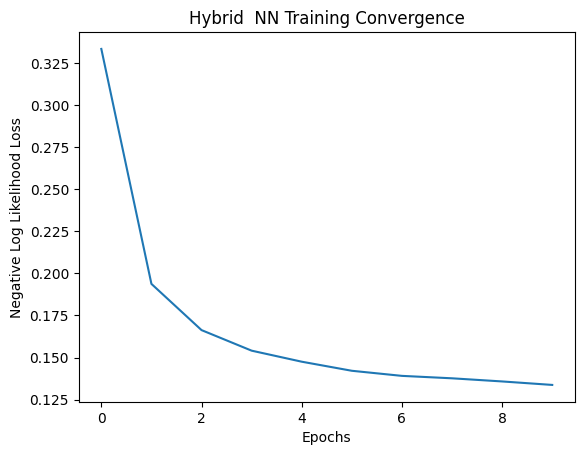

In [37]:
plt.plot(loss_list)
plt.title('Hybrid  NN Training Convergence')
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood Loss')
plt.show()

In [38]:
# #test loader
# n_samples = 50
# X_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

# # Filter for labels 0 and 1
# idx = np.append(
#     np.where(X_test.targets == 0)[0][:n_samples],
#     np.where(X_test.targets == 1)[0][:n_samples]
# )

# # Subset the data and targets
# X_test.data = X_test.data[idx]
# X_test.targets = X_test.targets[idx]

# # Create DataLoader
# test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [41]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

model.eval()
total_loss = []
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for data, target in test_loader:
        # Convert one-hot targets to class indices
        target_indices = target.argmax(dim=1)
        output = model(data)
        loss = loss_func(output, target_indices)
        total_loss.append(loss.item())

        # Store probabilities for AUROC
        probs = F.softmax(output, dim=1).cpu().numpy()
        all_probs.extend(probs)

        pred = output.argmax(dim=1).cpu().numpy()
        all_preds.extend(pred)
        all_labels.extend(target_indices.cpu().numpy())

avg_loss = sum(total_loss) / len(total_loss)
accuracy = (np.array(all_preds) == np.array(all_labels)).mean() * 100
f1 = f1_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')

# AUROC calculation - fix the shape issue
all_labels_flat = np.array(all_labels)
if all_labels_flat.ndim > 1:
    all_labels_flat = all_labels_flat.argmax(axis=1)

all_probs_array = np.array(all_probs)
# For binary classification, use only the probabilities for the positive class (class 1)
if all_probs_array.shape[1] == 2:
    # Use probabilities for class 1 only
    prob_positive_class = all_probs_array[:, 1]
    auroc = roc_auc_score(all_labels_flat, prob_positive_class)
else:
    # Fallback for other cases
    auroc = roc_auc_score(all_labels_flat, all_probs_array, average='macro', multi_class='ovo')

print(f"Average Test Loss: {avg_loss:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Macro-F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUROC Score: {auroc:.4f}")

# Additional info
print(f"\nDataset info:")
print(f"Number of test samples: {len(all_labels)}")
print(f"Prediction distribution: {np.bincount(all_preds)}")
print(f"True label distribution: {np.bincount(all_labels)}")

Average Test Loss: 0.1704
Test Accuracy: 100.00%
Macro-F1 Score: 1.0000
Precision: 1.0000
Recall: 1.0000
AUROC Score: 1.0000

Dataset info:
Number of test samples: 1897
Prediction distribution: [ 894 1003]
True label distribution: [ 894 1003]


Confusion Matrix:
 [[ 894    0]
 [   0 1003]]


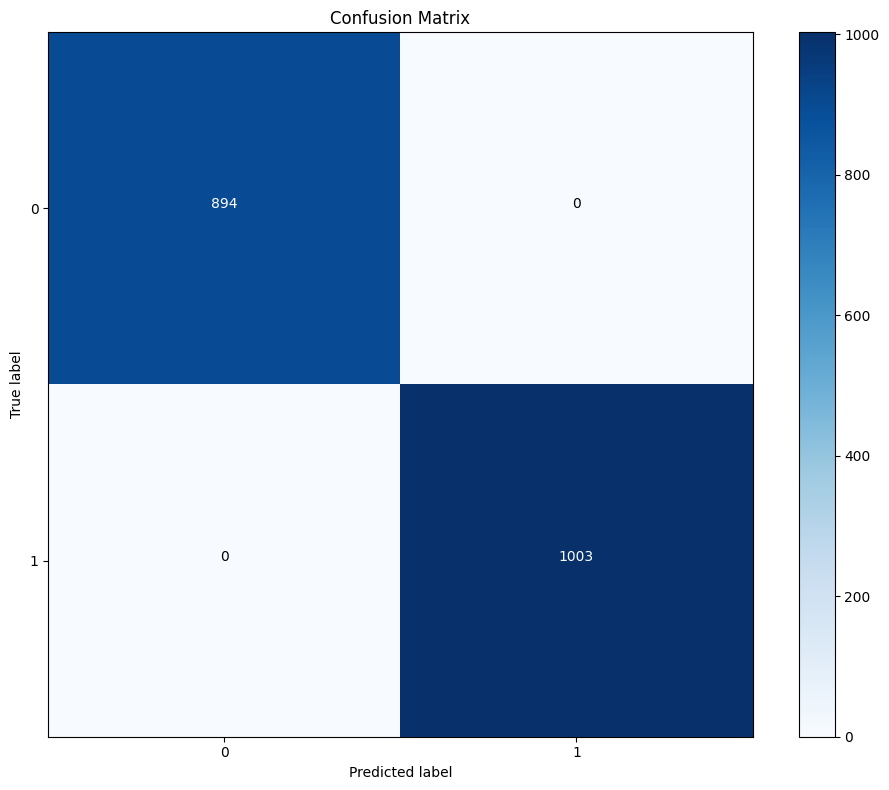

In [42]:
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()